# Clustering on DeepFold Embeddings
Haerang Lee

I'm going to take Skyler's DeepFold embeddings. Those files are in `embeddings/DeepFold` in the GCS bucket.

Then let me run some clustering models on top of it.

**Silly question**: If I want to put this notebook under a directory, how do I access `utils` in the parent directory? Right now I just put my notebook in the home dir.

In [1]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs

In [2]:
# Get all the keys from gcs
allkeys = gcs.list_keys()

In [3]:
# What's in here?
allkeys[0:10]

['/annotations/blast_annotations.csv',
 'UP000005640_9606_HUMAN.tar',
 'UP000005640_9606_HUMAN/cif/AF-A0A024R1R8-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A024RBG1-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A024RCN7-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H5-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H7-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H8-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H9-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6I0-F1-model_v1.cif.gz']

In [4]:
# How many files are there?
len(allkeys)

46812

In [5]:
# I just want the DeepFold embedding files
for k in allkeys:
    if "embed" in k:
        print(k)

embeddings/
embeddings/DeepFold/
embeddings/DeepFold/embeddings_0.csv
embeddings/DeepFold/embeddings_1.csv
embeddings/DeepFold/embeddings_10.csv
embeddings/DeepFold/embeddings_11.csv
embeddings/DeepFold/embeddings_12.csv
embeddings/DeepFold/embeddings_13.csv
embeddings/DeepFold/embeddings_14.csv
embeddings/DeepFold/embeddings_15.csv
embeddings/DeepFold/embeddings_16.csv
embeddings/DeepFold/embeddings_17.csv
embeddings/DeepFold/embeddings_18.csv
embeddings/DeepFold/embeddings_19.csv
embeddings/DeepFold/embeddings_2.csv
embeddings/DeepFold/embeddings_20.csv
embeddings/DeepFold/embeddings_21.csv
embeddings/DeepFold/embeddings_22.csv
embeddings/DeepFold/embeddings_23.csv
embeddings/DeepFold/embeddings_3.csv
embeddings/DeepFold/embeddings_4.csv
embeddings/DeepFold/embeddings_5.csv
embeddings/DeepFold/embeddings_6.csv
embeddings/DeepFold/embeddings_7.csv
embeddings/DeepFold/embeddings_8.csv
embeddings/DeepFold/embeddings_9.csv


In [6]:
prefix = 'embeddings/DeepFold'
keys = gcs.list_file_paths(prefix)

There are 24 files in the embeddings folder, each containing 1,000 proteins (except the last one). Here are the file names.

In [7]:
keys

['gs://capstone-fall21-protein/embeddings/DeepFold/',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_0.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_1.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_10.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_11.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_12.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_13.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_14.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_15.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_16.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_17.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_18.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_19.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_2.csv',
 'gs://capstone-fall21-pro

One of those embeddings files contains 1,000 proteins.
The first three elements appear to be empty data, or just `'', '0', '1\n0'`. The remaining 2,000 are pairs of protein name and relevant embedding (2\*1000).

In [8]:
keys[1]

'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_0.csv'

In [65]:
key = gcs.uri_to_bucket_and_key(keys[22])[1]
key

'embeddings/DeepFold/embeddings_7.csv'

## Download and Parse DeepFold Embeddings

In [68]:
# Let me download one and play with it.
df_emb = gcs.download_text(key)

In [69]:
# Decode it then split it into a list.
df_emb_decode = df_emb.decode('utf-8').split(",")

In [70]:
# 2003 items, where the first few are not just metadata or empty strings
len(df_emb_decode)

2003

In [71]:
# Item index 3 is where the real data starts. That's the protein name.
df_emb_decode[0:4]

['', '0', '1\n0', 'AF-P52758-F1-model_v1']

In [75]:
# ... Followed by the 398-length vector that represents a DeepFold embedding
df_emb_decode[4]

'"[0.02314364 0.         0.         0.         0.         0.\n 0.21306136 0.         0.         0.         0.         0.\n 0.00894155 0.14864615 0.         0.16724743 0.         0.\n 0.         0.         0.14527881 0.         0.05551712 0.01512884\n 0.         0.         0.         0.03125526 0.         0.\n 0.08913685 0.         0.         0.         0.         0.\n 0.13471818 0.         0.         0.         0.         0.11604603\n 0.         0.         0.0529888  0.00097862 0.         0.\n 0.         0.         0.00811869 0.         0.         0.02698607\n 0.         0.         0.         0.         0.07556766 0.\n 0.18254162 0.00297375 0.         0.         0.         0.\n 0.         0.         0.02795849 0.         0.         0.06582197\n 0.         0.         0.04518154 0.         0.         0.\n 0.         0.         0.07439934 0.         0.1683139  0.\n 0.         0.         0.01760291 0.         0.07878704 0.01621049\n 0.         0.12183473 0.         0.02944913 0.         0.

In [91]:
# Let's figure out how to parse the DeepFold embedding. 
# There's a lot of funny stuff in here.
# First, get rid of the file number at the end and just keep the vector

sample_emb = df_emb_decode[6].rsplit('\n', 1)[0]

In [165]:
# Now get rid of the double quotes and brackets to just get the values of the array

sample_emb_np = np.array(sample_emb[2:-2].split())
sample_emb_np

array(['0.', '0.', '0.', '0.', '0.05980834', '0.', '0.11338624',
       '0.03886417', '0.02524441', '0.', '0.', '0.', '0.', '0.05950396',
       '0.01365902', '0.12355073', '0.00876983', '0.01822875',
       '0.09609001', '0.04257268', '0.04186481', '0.02684545',
       '0.03763113', '0.', '0.03659998', '0.', '0.', '0.', '0.059562',
       '0.', '0.06115272', '0.1620137', '0.03983198', '0.01684552',
       '0.02932842', '0.00660839', '0.00770707', '0.04277336',
       '0.01949005', '0.', '0.', '0.', '0.', '0.04254051', '0.07754262',
       '0.02618456', '0.', '0.', '0.', '0.', '0.', '0.', '0.01862345',
       '0.', '0.04642207', '0.', '0.', '0.07284059', '0.06610846',
       '0.12522222', '0.', '0.', '0.', '0.03716445', '0.', '0.',
       '0.04749022', '0.', '0.03763493', '0.0703754', '0.', '0.',
       '0.02273948', '0.', '0.00482177', '0.03592151', '0.', '0.', '0.',
       '0.', '0.00829109', '0.02022448', '0.12619579', '0.', '0.', '0.',
       '0.06418524', '0.', '0.', '0.09890323',

In [166]:
# Size is as expected 

sample_emb_np.shape

(398,)

In [125]:
# items 0-2 in the embedding file are not relevant. 
# Take the rest and convert into a numpy array 
    # First column is the protein names
    # Second  column is the DeepFold. vector (size 398)

np_emb = np.array(df_emb_decode[3:]).reshape(1000, 2)

'AF-P52758-F1-model_v1'

In [233]:
# Let's take those columns separately to clean it up

X=np_emb[:,1].reshape(1000,1)
protein=np_emb[:,0].reshape(1000,1)

In [236]:
X.shape

(1000, 1)

## Parsing function

In [234]:
def parse_deepfold_embedding(unparsed):
    """Given a single DeepFold vector in a text format, 
    drop the metadata and convert the into a numpy array."""
    
    return np.array([float(n) for n in unparsed[0].rsplit('\n', 1)[0][2:-2].split()])

In [301]:
# Map the custom parse function. 
# The result is in a list.

parsed_list = list(map(parse_deepfold_embedding, X))

# Proteins that are missing DeepFold emeddings

In [302]:
# Unfortunately, not every protein has a 398-D embedding.
# Let's find those out. 

missing=[]
for i in range(len(parsed_list)):
    if len(parsed_list[i])!= 398:
        missing.append(i)

In [295]:
# These proteisns are missing DeepFold embeddings

np_emb[missing, 0]

array(['AF-P53803-F1-model_v1', 'AF-P56378-F1-model_v1',
       'AF-P56381-F1-model_v1', 'AF-P58511-F1-model_v1',
       'AF-P62273-F1-model_v1', 'AF-P62328-F1-model_v1',
       'AF-P62891-F1-model_v1', 'AF-P62945-F1-model_v1',
       'AF-P63313-F1-model_v1', 'AF-P80294-F1-model_v1',
       'AF-P80297-F1-model_v1', 'AF-P84101-F1-model_v1',
       'AF-Q00LT1-F1-model_v1'], dtype='<U6076')

In [296]:
[len(embedding) for embedding in np_emb[missing, 1]]

[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [297]:
np_emb[missing, 1]

array(['\n60', '\n220', '\n221', '\n340', '\n551', '\n563', '\n600',
       '\n608', '\n648', '\n781', '\n782', '\n834', '\n987'],
      dtype='<U6076')

In [305]:
len(missing)

13

In [303]:
# Let's generate a clean dataset by eliminating the proteins with missing embeddings 
# We end up with 987 out of 1,000 proteins. 

X_clean = np.stack([x for i,x in enumerate(parsed_list) if i not in missing])
X_clean.shape

(987, 398)

In [299]:
protein_clean =  np.stack([x for i,x in enumerate(protein) if i not in missing])
protein_clean.shape

(987, 1)

# Clustering

In [316]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=5).fit(X_clean)

In [317]:
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[ -1 552]
 [  0   5]
 [  1 257]
 [  2  21]
 [  3  33]
 [  4   5]
 [  5  40]
 [  6  26]
 [  7  20]
 [  8   8]
 [  9   8]
 [ 10  12]]


---

# Hyperparam tuning

Next steps for me:
1. I’m going to add in some form of evaluation metrics. Exploring using BLAST or other more traditional cluster evaluation techniques like the Elbow method. Then I’ll try to figure out what a reasonable outcome means and how to optimize for it.
1. I’ll write the code to tune the hyperparams.
1. Finally, I am going to write a .py file to download all the proteins and run a DB scan on all the proteins, then tune the hyperparams.

## Ideal number of clusters for the data


DBSCAN takes two inputs: `eps` and `min_samples`. Since this is an unsupervised model, here are some validity functions I can use to determine the right hyperparam values. 

First, let me try the Silhouette coefficient.

In [319]:
from sklearn.metrics import silhouette_samples, silhouette_score


In [344]:
# Let's just use my data from above, where the size is 987.
range_min_samples = range(5, 200, 5)

for n in range_min_samples:
    clustering = DBSCAN(eps=1, min_samples=n).fit(X_clean)
    cluster_labels = clustering.labels_
    
    silhouette_avg = silhouette_score(X_clean, cluster_labels)
    print("min_samples = " + str(n) + ":", str(silhouette_avg))
    
    sample_silhouette_values = silhouette_samples(X_clean, cluster_labels)

min_samples = 5: 0.0878836258259686
min_samples = 10: 0.09233013108149128
min_samples = 15: 0.0931771750487543
min_samples = 20: 0.09302338428730225
min_samples = 25: 0.09592920073634915
min_samples = 30: 0.09522166192796085
min_samples = 35: 0.09503834723374222
min_samples = 40: 0.09623713712167237
min_samples = 45: 0.09623713712167237
min_samples = 50: 0.0965156529388127
min_samples = 55: 0.09798522659017606
min_samples = 60: 0.09615374573902442
min_samples = 65: 0.09707610885170077
min_samples = 70: 0.09736258993747669
min_samples = 75: 0.09768536284564597
min_samples = 80: 0.09777008789765693
min_samples = 85: 0.09847861209642206
min_samples = 90: 0.10008703778391964
min_samples = 95: 0.10021354866502505
min_samples = 100: 0.09867890593139018
min_samples = 105: 0.09945751277936156
min_samples = 110: 0.09945751277936156
min_samples = 115: 0.09945751277936156
min_samples = 120: 0.09975458237952906
min_samples = 125: 0.09957527231470707
min_samples = 130: 0.09957527231470707
min_sampl

In [336]:
sample_silhouette_values.shape

(987,)

## Euclidean distances between points

The parameter `eps` in DBSCAN represents the distance threshold below which the two points are considered neighbors to each other. I have no idea what the range of distances look like, so let me find out. 

A thorough way to do this is to find out the distance between every point and every other point. Given I have 1,000 points, I'll get 1,000^2 distances. It's OK to do with 1,000 points but may cause an issue with 23,000. We'll see.

Let me do the proper way first. Then, if I need to optimize it later, I'll sample and find the epsilons from the 23,000 full dataset.

In [367]:
X_clean.shape

(987, 398)

`sklearn.metrics.pairwise.euclidean_distances` calculates the euclidean distance between a pair of row vector x and y is computed as:
```dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))```

> However, this is not the most precise way of doing this computation, because this equation potentially suffers from “catastrophic cancellation”. Also, the distance matrix returned by this function may not be exactly symmetric as required by, e.g., scipy.spatial.distance functions.

Not sure what that means, but I'll figure it out.

[source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html)

In [368]:
from sklearn.metrics.pairwise import euclidean_distances
ed = euclidean_distances(X_clean, X_clean)
ed.shape

(987, 987)

So now I have a 987 by 987 matrix.

In [386]:
min_ed = np.min(ed)
min_ed

0.0

In [387]:
max_ed = np.max(ed)
max_ed

1.4114782477784376

In [384]:
np.median(ed)

1.203486147373727

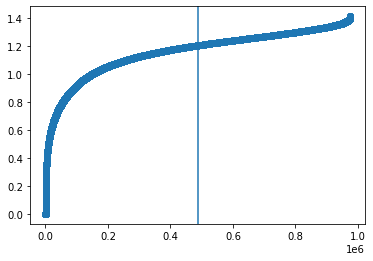

In [394]:
import matplotlib.pyplot as plt

plt.scatter(range(0,987**2), np.sort(ed.flatten()))
plt.axvline(987**2/2)
plt.show()

The euclidean distance among my 987 proteins range from 0 to 1.41, median is about 1.2. If I expect there to be 10-50 clusters within a dataset of 1,000 proteins, then I think my epsilon has got to be much smaller than this median. 

Try different epsilons now.

In [395]:
range_eps = np.linspace(start=0.1, stop=1.0, num=10)

for n in range_eps:
    clustering = DBSCAN(eps=n, min_samples=10).fit(X_clean)
    cluster_labels = clustering.labels_
    
    if len(np.unique(cluster_labels))==1:
        print("eps = " + str(round(n, 2)) + ": Everything is a noise!")
    else:
        silhouette_avg = silhouette_score(X_clean, cluster_labels)
        print("eps = " + str(round(n, 2)) + ":", 
              str(round(silhouette_avg, 4)))

        sample_silhouette_values = silhouette_samples(X_clean, cluster_labels)

eps = 0.1: Everything is a noise!
eps = 0.2: -0.0065
eps = 0.3: -0.1116
eps = 0.4: 0.0274
eps = 0.5: 0.0745
eps = 0.6: 0.1006
eps = 0.7: 0.0621
eps = 0.8: 0.0858
eps = 0.9: 0.0836
eps = 1.0: 0.0923


Now let's try doing a manual grid search. We want to maximize the silouette score.

In [407]:
range_eps = np.linspace(start=0.1, stop=1.0, num=10)
range_min_samples = range(10, 200, 10)


def dbscan_gridsearch(X, range_eps, range_min_samples):
    search_results = []
    for i in range_eps:
        for j in range_min_samples:
            clustering = DBSCAN(eps=i, min_samples=j).fit(X)
            cluster_labels = clustering.labels_

            if len(np.unique(cluster_labels))==1:
                print("eps=" + str(round(i, 2)) + ", min_samples=" + str(j)  
                      + ": Everything is a noise!")
            else:
                silhouette_avg = silhouette_score(X_clean, cluster_labels)
                print("eps=" + str(round(i, 2)) + ", min_samples=" + str(j) +": " 
                      + str(round(silhouette_avg, 4)))
                search_results.append(((i, j), silhouette_avg))

    return sorted(search_results, key=lambda x: x[1], reverse=True)

search_results = dbscan_gridsearch(X_clean, range_eps, range_min_samples)

eps=0.1, min_samples=10: Everything is a noise!
eps=0.1, min_samples=20: Everything is a noise!
eps=0.1, min_samples=30: Everything is a noise!
eps=0.1, min_samples=40: Everything is a noise!
eps=0.1, min_samples=50: Everything is a noise!
eps=0.1, min_samples=60: Everything is a noise!
eps=0.1, min_samples=70: Everything is a noise!
eps=0.1, min_samples=80: Everything is a noise!
eps=0.1, min_samples=90: Everything is a noise!
eps=0.1, min_samples=100: Everything is a noise!
eps=0.1, min_samples=110: Everything is a noise!
eps=0.1, min_samples=120: Everything is a noise!
eps=0.1, min_samples=130: Everything is a noise!
eps=0.1, min_samples=140: Everything is a noise!
eps=0.1, min_samples=150: Everything is a noise!
eps=0.1, min_samples=160: Everything is a noise!
eps=0.1, min_samples=170: Everything is a noise!
eps=0.1, min_samples=180: Everything is a noise!
eps=0.1, min_samples=190: Everything is a noise!
eps=0.2, min_samples=10: -0.0065
eps=0.2, min_samples=20: Everything is a nois

In [408]:
search_results

[((0.6, 10), 0.10062334395122446),
 ((1.0, 180), 0.10019600298927343),
 ((1.0, 90), 0.10008703778391964),
 ((1.0, 170), 0.09996879475275447),
 ((1.0, 160), 0.09994635643362708),
 ((1.0, 190), 0.099843383104516),
 ((1.0, 120), 0.09975458237952906),
 ((1.0, 150), 0.09968969400558335),
 ((0.9, 30), 0.09966479716754044),
 ((1.0, 130), 0.09957527231470707),
 ((1.0, 110), 0.09945751277936156),
 ((1.0, 140), 0.09940835589336891),
 ((1.0, 100), 0.09867890593139018),
 ((1.0, 80), 0.09777008789765693),
 ((1.0, 70), 0.09736258993747669),
 ((1.0, 50), 0.0965156529388127),
 ((0.9, 60), 0.09642652017197094),
 ((0.9, 190), 0.09629273988643941),
 ((0.9, 180), 0.09625210701405415),
 ((0.9, 80), 0.09624053687037468),
 ((1.0, 40), 0.09623713712167237),
 ((1.0, 60), 0.09615374573902442),
 ((0.9, 50), 0.09614604537402098),
 ((0.9, 100), 0.09604364933028252),
 ((0.9, 70), 0.09601265971793706),
 ((0.9, 110), 0.0959877864207942),
 ((0.9, 120), 0.0959877864207942),
 ((0.9, 130), 0.09568807086067671),
 ((0.9, 9

Looks like the winner is: `eps=0.6, min_samples=10`

Now that we have a working grid search of sorts, let's try working on the entire dataset.

# Full dataset

In [410]:
# This is the list of file paths in gcs 
len(keys[1:])

24

In [414]:
protein_clean.shape

(987, 1)

In [550]:
missing = np.empty((0,1))
missing

array([], shape=(0, 1), dtype=float64)

In [551]:
np.append(missing, "2")

array(['2'], dtype='<U32')

In [554]:
missing = np.append(missing, "2")
missing

array(['2', '2', '2'], dtype='<U32')

In [556]:
missing_full=[]
X_hold = [] 
protein_name_hold = []
z=0

for key in keys[1:]:
    missing=np.empty((0,1))
    z+=1 
    # Loop through all 24 DeepFold embedding files
    
    # I actually only need the file path once in the right storage.
    key = gcs.uri_to_bucket_and_key(key)[1]
    
    
    # Download, decode, and split into list. Ignore first 3 items.
    df_emb = gcs.download_text(key)\
             .decode('utf-8').split(",")[3:]
    
    n_proteins = int((len(df_emb))/2)
    
    
    # Take as np array and reshape
    np_emb = np.array(df_emb).reshape(n_proteins, 2)
    
    # Now take the embeddings and protein names separately. 
    X=np_emb[:,1].reshape(n_proteins,1)
    protein=np_emb[:,0].reshape(n_proteins,1)
    
    # Parse the values of embeddings
    parsed_list = list(map(parse_deepfold_embedding, X))
    print(z, key, n_proteins, len(parsed_list))
    
    # Identify proteins where the DeepFold embeddings could not be generated
    for i in range(len(parsed_list)):
        if len(parsed_list[i])!= 398:
            missing = np.append(missing, i)
    
    # Take the remainder and stack.
    print("missing", len(missing))
    X_clean = np.stack([x for i,x in enumerate(parsed_list) if i not in missing])
    
    protein_clean =  np.stack([x for i,x in enumerate(protein) if i not in missing])
    
    X_hold.append(X_clean)
    protein_name_hold.append(protein_clean)
    
    missing_full.append(missing)
    
X_full = np.vstack(X_hold)
protein_name_full = np.vstack(protein_name_hold)

1 embeddings/DeepFold/embeddings_0.csv 1000 1000
2 embeddings/DeepFold/embeddings_1.csv 1000 1000
3 embeddings/DeepFold/embeddings_10.csv 1000 1000
4 embeddings/DeepFold/embeddings_11.csv 1000 1000
5 embeddings/DeepFold/embeddings_12.csv 1000 1000
6 embeddings/DeepFold/embeddings_13.csv 1000 1000
7 embeddings/DeepFold/embeddings_14.csv 1000 1000
8 embeddings/DeepFold/embeddings_15.csv 1000 1000
9 embeddings/DeepFold/embeddings_16.csv 1000 1000
10 embeddings/DeepFold/embeddings_17.csv 1000 1000
11 embeddings/DeepFold/embeddings_18.csv 1000 1000
12 embeddings/DeepFold/embeddings_19.csv 1000 1000
13 embeddings/DeepFold/embeddings_2.csv 1000 1000
14 embeddings/DeepFold/embeddings_20.csv 1000 1000
15 embeddings/DeepFold/embeddings_21.csv 1000 1000
16 embeddings/DeepFold/embeddings_22.csv 1000 1000
17 embeddings/DeepFold/embeddings_23.csv 391 391
18 embeddings/DeepFold/embeddings_3.csv 1000 1000
19 embeddings/DeepFold/embeddings_4.csv 1000 1000
20 embeddings/DeepFold/embeddings_5.csv 1000 10

In [557]:
len(X_hold)

24

In [559]:
X_full.shape

(23188, 398)

In [561]:
protein_name_full.shape

(23188, 1)

In [558]:
t = 0
for x in X_hold:
    t += len(x)
    print(len(x), t)

931 931
995 1926
982 2908
996 3904
1000 4904
993 5897
998 6895
997 7892
997 8889
993 9882
999 10881
995 11876
999 12875
996 13871
994 14865
999 15864
384 16248
993 17241
971 18212
997 19209
998 20207
987 21194
996 22190
998 23188


In [560]:
t = 0
for missing in missing_full:
    t+= len (missing)
    print(len (missing), t)
    

69 69
5 74
18 92
4 96
0 96
7 103
2 105
3 108
3 111
7 118
1 119
5 124
1 125
4 129
6 135
1 136
7 143
7 150
29 179
3 182
2 184
13 197
4 201
2 203


## Cluster full data

In [563]:
ed = euclidean_distances(X_full, X_full)
ed.shape

(23188, 23188)

In [564]:
min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)

0.0 1.4139664121859254 1.1273183258469868


In [566]:
ed_flatten = ed.flatten()

In [567]:
ed_flatten.shape

(537683344,)

In [569]:
sample_ed = np.random.choice(ed_flatten, 10000)

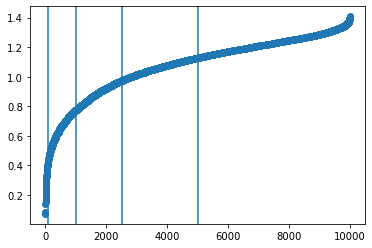

In [570]:
plt.scatter(range(len(sample_ed)), np.sort(sample_ed))
plt.axvline(len(sample_ed)/2)
plt.axvline(len(sample_ed)/4)
plt.axvline(len(sample_ed)/10)
plt.axvline(len(sample_ed)/100)
plt.show()

In [571]:
range_eps = np.linspace(start=0.01, stop=0.4, num=50)
range_min_samples = [2, 4, 6, 10, 15, 20]

search_results = dbscan_gridsearch(X_clean, range_eps, range_min_samples)

eps=0.01, min_samples=2: Everything is a noise!
eps=0.01, min_samples=4: Everything is a noise!
eps=0.01, min_samples=6: Everything is a noise!
eps=0.01, min_samples=10: Everything is a noise!
eps=0.01, min_samples=15: Everything is a noise!
eps=0.01, min_samples=20: Everything is a noise!
eps=0.02, min_samples=2: Everything is a noise!
eps=0.02, min_samples=4: Everything is a noise!
eps=0.02, min_samples=6: Everything is a noise!
eps=0.02, min_samples=10: Everything is a noise!
eps=0.02, min_samples=15: Everything is a noise!
eps=0.02, min_samples=20: Everything is a noise!
eps=0.03, min_samples=2: Everything is a noise!
eps=0.03, min_samples=4: Everything is a noise!
eps=0.03, min_samples=6: Everything is a noise!
eps=0.03, min_samples=10: Everything is a noise!
eps=0.03, min_samples=15: Everything is a noise!
eps=0.03, min_samples=20: Everything is a noise!
eps=0.03, min_samples=2: -0.1316
eps=0.03, min_samples=4: Everything is a noise!
eps=0.03, min_samples=6: Everything is a noise

eps=0.3, min_samples=20: -0.0669
eps=0.31, min_samples=2: -0.1598
eps=0.31, min_samples=4: -0.1168
eps=0.31, min_samples=6: -0.1263
eps=0.31, min_samples=10: -0.062
eps=0.31, min_samples=15: -0.0696
eps=0.31, min_samples=20: -0.0654
eps=0.32, min_samples=2: -0.1502
eps=0.32, min_samples=4: -0.1503
eps=0.32, min_samples=6: -0.1146
eps=0.32, min_samples=10: -0.0574
eps=0.32, min_samples=15: -0.0654
eps=0.32, min_samples=20: -0.0641
eps=0.33, min_samples=2: -0.1513
eps=0.33, min_samples=4: -0.1031
eps=0.33, min_samples=6: -0.0763
eps=0.33, min_samples=10: -0.0421
eps=0.33, min_samples=15: -0.0535
eps=0.33, min_samples=20: -0.0536
eps=0.34, min_samples=2: -0.131
eps=0.34, min_samples=4: -0.0946
eps=0.34, min_samples=6: -0.1082
eps=0.34, min_samples=10: -0.0346
eps=0.34, min_samples=15: -0.046
eps=0.34, min_samples=20: -0.0456
eps=0.34, min_samples=2: -0.1315
eps=0.34, min_samples=4: -0.0896
eps=0.34, min_samples=6: -0.0729
eps=0.34, min_samples=10: -0.0709
eps=0.34, min_samples=15: -0.0356

In [496]:
search_results

[((0.4, 10), 0.023467822475349814),
 ((0.39204081632653065, 10), 0.0214777922486603),
 ((0.4, 15), 0.01930870219974042),
 ((0.3840816326530612, 10), 0.017719496935435494),
 ((0.37612244897959185, 10), 0.013208455638236978),
 ((0.39204081632653065, 15), 0.011654616479258749),
 ((0.4, 20), 0.010349287209099754),
 ((0.3840816326530612, 15), 0.009689977968223702),
 ((0.3681632653061225, 10), 0.008606833435016573),
 ((0.39204081632653065, 20), 0.007100332750327662),
 ((0.3840816326530612, 20), 0.004994796522623577),
 ((0.37612244897959185, 20), 0.0013549210744928921),
 ((0.37612244897959185, 15), -0.0009008930501418622),
 ((0.3681632653061225, 15), -0.003893752562267564),
 ((0.36020408163265305, 15), -0.023427658934734245),
 ((0.256734693877551, 20), -0.02448929029747061),
 ((0.2646938775510204, 20), -0.02487744974089868),
 ((0.3681632653061225, 20), -0.02492840644936101),
 ((0.24877551020408165, 20), -0.02548618580777458),
 ((0.36020408163265305, 20), -0.02989718143338908),
 ((0.4, 4), -0.

In [483]:
# At first, the grid search tried to tell me eps=0.6 was good
clustering = DBSCAN(eps=0.6, min_samples=25).fit(X_full)

In [484]:
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1  5601]
 [    0 14499]
 [    1   242]
 [    2   104]
 [    3    39]]


Oh no, the epsilon is too generous. So I ran grid search again but limited eps to 0.4. Anything below that would give me only negative Silhouette scores.

In [572]:
clustering = DBSCAN(eps=0.4, min_samples=10).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1 11434]
 [    0 10544]
 [    1   224]
 [    2     9]
 [    3    11]
 [    4    72]
 [    5    15]
 [    6    10]
 [    7    17]
 [    8    16]
 [    9    86]
 [   10    12]
 [   11    95]
 [   12    19]
 [   13    15]
 [   14    14]
 [   15    15]
 [   16    53]
 [   17    20]
 [   18    11]
 [   19    39]
 [   20    11]
 [   21    22]
 [   22    70]
 [   23    13]
 [   24    16]
 [   25    12]
 [   26    16]
 [   27    17]
 [   28    11]
 [   29    20]
 [   30    23]
 [   31    12]
 [   32    30]
 [   33    13]
 [   34    35]
 [   35    12]
 [   36    18]
 [   37    13]
 [   38    17]
 [   39    10]
 [   40    12]
 [   41    10]
 [   42    24]
 [   43    20]]


The cluster sizes look OK now, but almost half the proteins are considered noise, and 40% are in cluster index 0.

In [573]:
clustering = DBSCAN(eps=0.5, min_samples=10).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1  7937]
 [    0 14182]
 [    1   245]
 [    2    11]
 [    3    11]
 [    4    19]
 [    5    16]
 [    6    10]
 [    7    18]
 [    8    36]
 [    9   120]
 [   10    41]
 [   11    11]
 [   12    20]
 [   13    15]
 [   14    21]
 [   15    12]
 [   16    15]
 [   17    13]
 [   18   107]
 [   19    12]
 [   20    20]
 [   21    22]
 [   22    15]
 [   23    12]
 [   24    39]
 [   25    11]
 [   26    15]
 [   27    11]
 [   28    16]
 [   29    10]
 [   30    18]
 [   31    13]
 [   32    12]
 [   33     9]
 [   34    10]
 [   35    18]
 [   36    14]
 [   37     7]
 [   38    24]
 [   39    10]
 [   40    10]]


Even 0.5 is too generous for an epsilon. See how big cluster 0 is!

In [574]:
# So I guess eps=0.4 it is. 
clustering = DBSCAN(eps=0.40, min_samples=5).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1 10211]
 [    0 11243]
 [    1     5]
 [    2   234]
 [    3     5]
 [    4     5]
 [    5     9]
 [    6    11]
 [    7     8]
 [    8     5]
 [    9    15]
 [   10    10]
 [   11     7]
 [   12     5]
 [   13     5]
 [   14    17]
 [   15    16]
 [   16     5]
 [   17     7]
 [   18     6]
 [   19     6]
 [   20    12]
 [   21    98]
 [   22     8]
 [   23    10]
 [   24    19]
 [   25     5]
 [   26     6]
 [   27    15]
 [   28    14]
 [   29    71]
 [   30     7]
 [   31    12]
 [   32    14]
 [   33     8]
 [   34    20]
 [   35    11]
 [   36     6]
 [   37     8]
 [   38     5]
 [   39     5]
 [   40     9]
 [   41     6]
 [   42     5]
 [   43    18]
 [   44     7]
 [   45     7]
 [   46     9]
 [   47     5]
 [   48    11]
 [   49     5]
 [   50     9]
 [   51    16]
 [   52     6]
 [   53    22]
 [   54     6]
 [   55    69]
 [   56     4]
 [   57     4]
 [   58    13]
 [   59    13]
 [   60     9]
 [   61    12]
 [   62    39]
 [   63     9]
 [   64    17]
 [   65   

Still almost half of the points are considered noise. Can I reduce it if I lower the min_samples param?

In [575]:
clustering = DBSCAN(eps=0.40, min_samples=2).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1  7490]
 [    0 11612]
 [    1     5]
 ...
 [ 1126     2]
 [ 1127     2]
 [ 1128     2]]


So the noise went down somewhat, but still substantial. And cluster 0 is still too big.